The data comes from https://www.kaggle.com/competitions/store-sales-time-series-forecasting/data

The purpose here is the prediction the sales of the thousand of products families sold at Favorita stores located in Ecuador.

In [ ]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
import os
import gc
import warnings

In [ ]:
# CONFIGURATIONS
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format
warnings.filterwarnings('ignore')

In [ ]:
# Import datasets
train = pd.read_csv("train.csv")
stores = pd.read_csv("stores.csv")
transactions = pd.read_csv("transactions.csv").sort_values(["store_nbr", "date"])
oil = pd.read_csv("oil.csv")
holidays = pd.read_csv("holidays_events.csv")

print("The train data \n")
print(train.head())

print("The stores data \n")
print(stores.head())

print("The transactions data \n")
print(transactions.head())

print("The oil price data \n")
print(oil.head())

In [ ]:
# Datetime
train["date"] = pd.to_datetime(train.date)
transactions["date"] = pd.to_datetime(transactions.date)
oil["date"] = pd.to_datetime(oil.date)
holidays["date"] = pd.to_datetime(holidays.date)

# Data types
train.onpromotion = train.onpromotion.astype("float16")
train.sales = train.sales.astype("float32")
stores.cluster = stores.cluster.astype("int8")

In [ ]:
# Correlation between sales and transactions
temp = pd.merge(train.groupby(["date", "store_nbr"]).sales.sum().reset_index(), transactions, how = "left")
print("Spearman Correlation between Total Sales and Transactions: {:,.4f}".format(temp.corr("spearman").sales.loc["transactions"]))

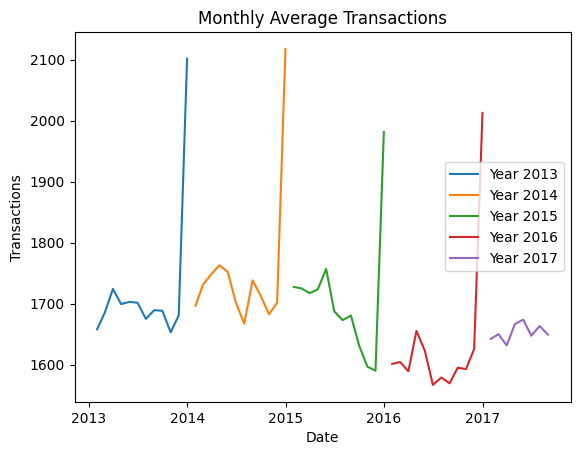

In [ ]:
a = transactions.set_index("date").resample("M").transactions.mean().reset_index()
a["year"] = a.date.dt.year

for year, year_data in a.groupby("year"):
    plt.plot(year_data["date"], year_data["transactions"], label=f'Year {year}')
plt.title("Monthly Average Transactions")
plt.xlabel("Date")
plt.ylabel("Transactions")
plt.legend()
plt.show()

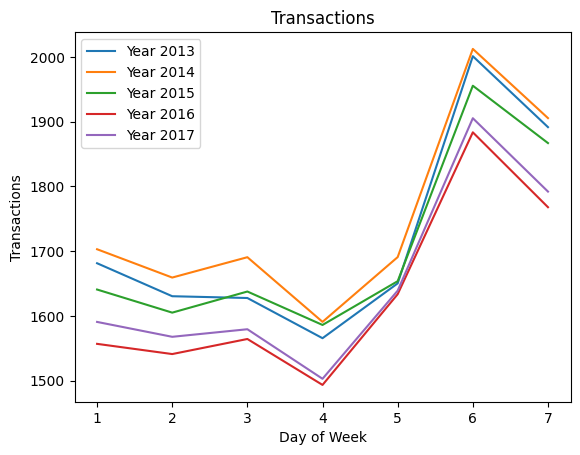

In [ ]:
a = transactions.copy()
a["year"] = a.date.dt.year
a["dayofweek"] = a.date.dt.dayofweek + 1
a = a.groupby(["year", "dayofweek"]).transactions.mean().reset_index()

for year, year_data in a.groupby("year"):
    plt.plot(year_data["dayofweek"], year_data["transactions"], label=f'Year {year}')
plt.title("Transactions")
plt.xlabel("Day of Week")
plt.ylabel("Transactions")
plt.legend()
plt.show()

         date  dcoilwtico  dcoilwtico_interpolated
0  2013-01-01         NaN                    93.14
1  2013-01-02       93.14                    93.14
2  2013-01-03       92.97                    92.97
3  2013-01-04       93.12                    93.12
4  2013-01-05         NaN                    93.15
5  2013-01-06         NaN                    93.17
6  2013-01-07       93.20                    93.20
7  2013-01-08       93.21                    93.21
8  2013-01-09       93.08                    93.08
9  2013-01-10       93.81                    93.81
10 2013-01-11       93.60                    93.60
11 2013-01-12         NaN                    93.82
12 2013-01-13         NaN                    94.05
13 2013-01-14       94.27                    94.27
14 2013-01-15       93.26                    93.26
15 2013-01-16       94.28                    94.28
16 2013-01-17       95.49                    95.49
17 2013-01-18       95.61                    95.61
18 2013-01-19         NaN      

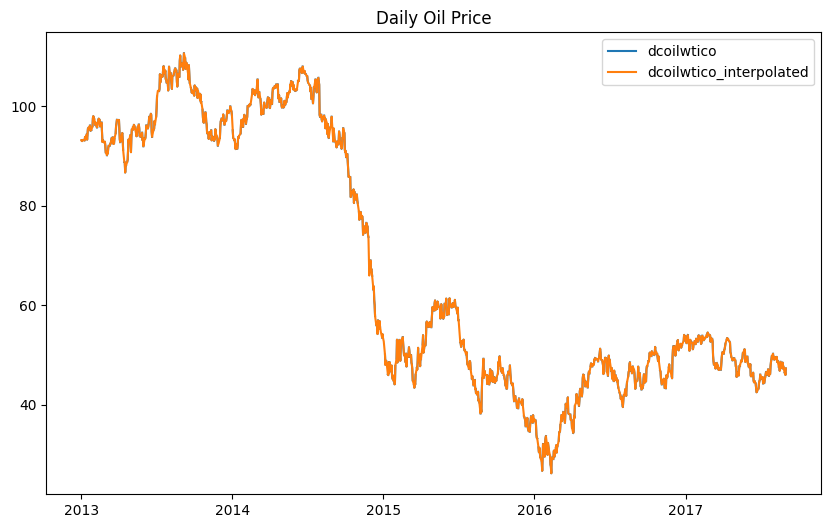

In [ ]:
# Oil
oil = oil.set_index("date").dcoilwtico.resample("D").sum().reset_index()
oil["dcoilwtico"] = np.where(oil["dcoilwtico"] == 0, np.nan, oil["dcoilwtico"])
oil["dcoilwtico_interpolated"] =oil.dcoilwtico.interpolate()
oil['dcoilwtico_interpolated'][0]= oil['dcoilwtico_interpolated'][1]
print(oil.head(40))

fig, ax = plt.subplots(figsize=(10, 6))

oil_melted = oil.melt(id_vars=['date'] + list(oil.keys()[5:]), var_name='Legend')
oil_sorted = oil_melted.sort_values(["Legend", "date"], ascending=[False, True])

for key, grp in oil_sorted.groupby('Legend'):
    ax.plot(grp['date'], grp['value'], label=key)

ax.set_title("Daily Oil Price")
ax.legend()
plt.show()

         date  daily_transactions  daily_transactions_interpolated
0  2013-01-01                 NaN                         93215.00
1  2013-01-02            93215.00                         93215.00
2  2013-01-03            78504.00                         78504.00
3  2013-01-04            78494.00                         78494.00
4  2013-01-05            93573.00                         93573.00
5  2013-01-06            90464.00                         90464.00
6  2013-01-07            75597.00                         75597.00
7  2013-01-08            72325.00                         72325.00
8  2013-01-09            71971.00                         71971.00
9  2013-01-10            66383.00                         66383.00
10 2013-01-11            70338.00                         70338.00
11 2013-01-12            85511.00                         85511.00
12 2013-01-13            86306.00                         86306.00
13 2013-01-14            70078.00                         7007

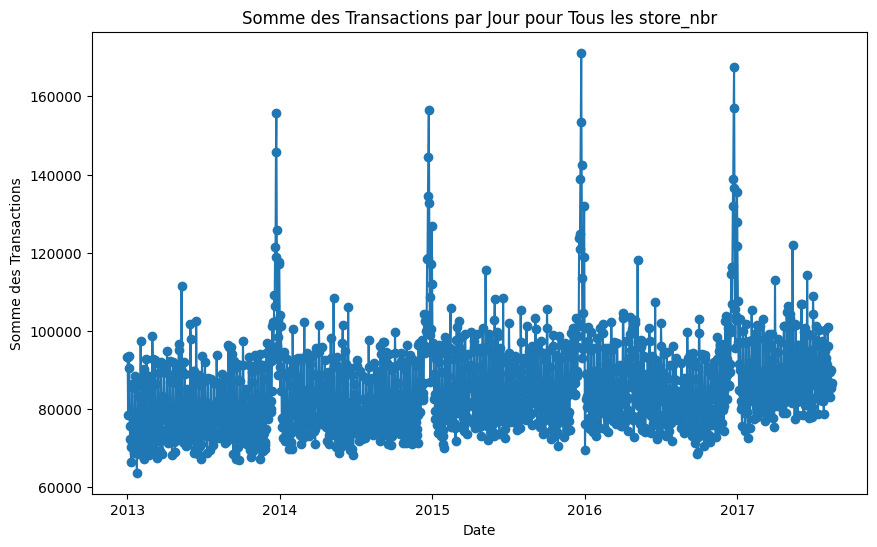

In [ ]:
# Transactions
daily_transactions = transactions.groupby('date')['transactions'].sum().reset_index()
daily_transactions = daily_transactions.rename(columns={'transactions': 'daily_transactions'})
daily_transactions = daily_transactions.set_index("date").daily_transactions.resample("D").sum().reset_index()
daily_transactions["daily_transactions"] = np.where(daily_transactions["daily_transactions"] <= 25000, np.nan, daily_transactions["daily_transactions"])
daily_transactions["daily_transactions_interpolated"] =daily_transactions.daily_transactions.interpolate()
daily_transactions['daily_transactions_interpolated'][0]= daily_transactions['daily_transactions_interpolated'][1]
print(daily_transactions.head(40))

plt.figure(figsize=(10, 6))
plt.plot(daily_transactions["date"], daily_transactions["daily_transactions_interpolated"], marker='o', linestyle='-')
plt.title('Somme des Transactions par Jour pour Tous les store_nbr')
plt.xlabel('Date')
plt.ylabel('Somme des Transactions')
plt.show()

In [ ]:
# Sales
daily_sales = train.groupby('date')['sales'].sum().reset_index()
daily_sales = daily_sales.rename(columns={'sales': 'daily_sales'})
daily_sales = daily_sales.set_index("date").daily_sales.resample("D").sum().reset_index()
daily_sales["daily_sales"] = np.where(daily_sales["daily_sales"] <= 200000, np.nan, daily_sales["daily_sales"])
daily_sales["daily_sales_interpolated"] =daily_sales.daily_sales.interpolate()
daily_sales['daily_sales_interpolated'][0]= daily_sales['daily_sales_interpolated'][1]
print(daily_sales.head(30))

plt.figure(figsize=(10, 6))
plt.plot(daily_sales["date"], daily_sales["daily_sales_interpolated"], marker='o', linestyle='-')
plt.title('Somme des daily_sales p')
plt.xlabel('Date')
plt.ylabel('Somme des daily_sales')
plt.show()

In [ ]:
# Onpromotion
daily_onpromotion = train.groupby('date')['onpromotion'].sum().reset_index()
daily_onpromotion = daily_onpromotion.rename(columns={'onpromotion': 'daily_onpromotion'})
daily_onpromotion = daily_onpromotion.set_index("date").daily_onpromotion.resample("D").sum().reset_index()
daily_onpromotion["daily_onpromotion"] = np.where(daily_onpromotion["daily_onpromotion"] == 0, np.nan, daily_onpromotion["daily_onpromotion"])

january_first_2013 = daily_onpromotion[daily_onpromotion['date'] == '2013-01-01'].index[0]
january_first_2014 = daily_onpromotion[daily_onpromotion['date'] == '2014-01-01'].index[0]
january_first_2015 = daily_onpromotion[daily_onpromotion['date'] == '2015-01-01'].index[0]
january_first_2016 = daily_onpromotion[daily_onpromotion['date'] == '2016-01-01'].index[0]
january_first_2017 = daily_onpromotion[daily_onpromotion['date'] == '2017-01-01'].index[0]
daily_onpromotion["daily_onpromotion"][january_first_2013] = np.nan
daily_onpromotion["daily_onpromotion"][january_first_2014] = np.nan
daily_onpromotion["daily_onpromotion"][january_first_2015] = np.nan
daily_onpromotion["daily_onpromotion"][january_first_2016] = np.nan
daily_onpromotion["daily_onpromotion"][january_first_2017] = np.nan

daily_onpromotion["daily_onpromotion_interpolated"] = daily_onpromotion.daily_onpromotion.interpolate()

start_date = '2013-01-01'
end_date = '2014-03-31'
mask = (daily_onpromotion['date'] >= start_date) & (daily_onpromotion['date'] <= end_date)
daily_onpromotion.loc[mask, 'daily_onpromotion_interpolated'] = daily_onpromotion.loc[mask, 'daily_onpromotion_interpolated'].fillna(0)
print(daily_onpromotion.tail(30))

plt.figure(figsize=(10, 6))
plt.plot(daily_onpromotion["date"], daily_onpromotion["daily_onpromotion_interpolated"], marker='o', linestyle='-')
plt.title('Somme des daily_onpromotion par Jour pour tous les store_nbr')
plt.xlabel('Date')
plt.ylabel('Somme des daily_onpromotion')
plt.show()

In [ ]:
# Holidays
national_holidays = holidays[(holidays['locale'] == 'National') & (holidays['date'] >= '2013-01-01')& (holidays['date'] <= '2017-08-15')]
national_holidays['is_national_holidays'] = 1
is_national_holidays = national_holidays[['date', 'is_national_holidays']].set_index("date").is_national_holidays.resample("D").sum().reset_index()
print(is_national_holidays.head(30))

In [ ]:
# The overall dataset
final_dataset = pd.merge(daily_sales[['date', 'daily_sales_interpolated']], daily_transactions[['date', 'daily_transactions_interpolated']], on='date', how='inner')
final_dataset = pd.merge(final_dataset, daily_onpromotion[['date', 'daily_onpromotion_interpolated']], on='date', how='inner')
final_dataset = pd.merge(final_dataset, oil[['date', 'dcoilwtico_interpolated']], on='date', how='inner')
final_dataset = pd.merge(final_dataset, is_national_holidays, on='date', how='inner')
final_dataset['month'] = final_dataset['date'].dt.month
final_dataset['day_of_week'] = final_dataset['date'].dt.dayofweek + 1

print(final_dataset.head(30))

#final_dataset.to_csv("/home/damien.chanet/DEEPL_S5/Project/final_dataset.csv", index=False)

NameError: ignored